In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

# Load the data
data = pd.read_csv('../notebooks/data/merged_data.csv')

print(f'dataframe shape: {data.shape}')

dataframe shape: (1305, 344)


## Analyze nulls that come from missing urine tests
Each week urine is tested for 9 different drug classes.  If all 9 drug tests are missing, patient is considered missing from treatment

In [15]:
# create 24 dataframes, for each week of treatment
for i in range(1, 25):
    
    # name each dataframe week+number (week of treatment), including all relevent columns
    globals()[f'week_{i}'] = data[['patdeid']+[col for col in data.columns if col.startswith('test') and col.endswith(f'_{i}')]]
    
    # create a new column 'missed_tests{i}' for each week, count all the missing vlaues, if count equals 9 then 1 for missing test else 0
    globals()[f'week_{i}'][f'missed_tests{i}'] = np.where(globals()[f'week_{i}'].isna().sum(axis=1) == 9, 1, 0)

    # merge all dfs together
    if i == 1:
        merged = globals()[f'week_{i}'] # add the first week of clinical data to merged dataframe
    else:
        merged = pd.merge(merged, globals()[f'week_{i}'], on='patdeid', how='left') # use left merge to preserve patdeid as key column

# drop columns except for missed_tests{i}, keep patdeid as primary key
merged = merged[['patdeid']+[col for col in merged.columns if 'missed_tests' in col]] 

# rename columns for easier reading
merged.columns = merged.columns.str.replace('missed_tests', '')

# sum all the missed_tests{i} columns to get the total missed tests
merged['missed_tests'] = merged.iloc[:, 1:].sum(axis=1)

# add medication column to merged dataframe
merged['meds'] = data['medication']

# obesrve 15 random instances of tests and the outcome columsn to the far right
merged.sample(15)

,patdeid,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,missed_tests,meds
1243,1846,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,18,2.0
334,520,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2.0
1283,1902,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,16,1.0
1242,1845,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
347,540,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
635,957,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
72,107,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,12,2.0
1217,1813,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
1021,1525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
116,175,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,22,2.0


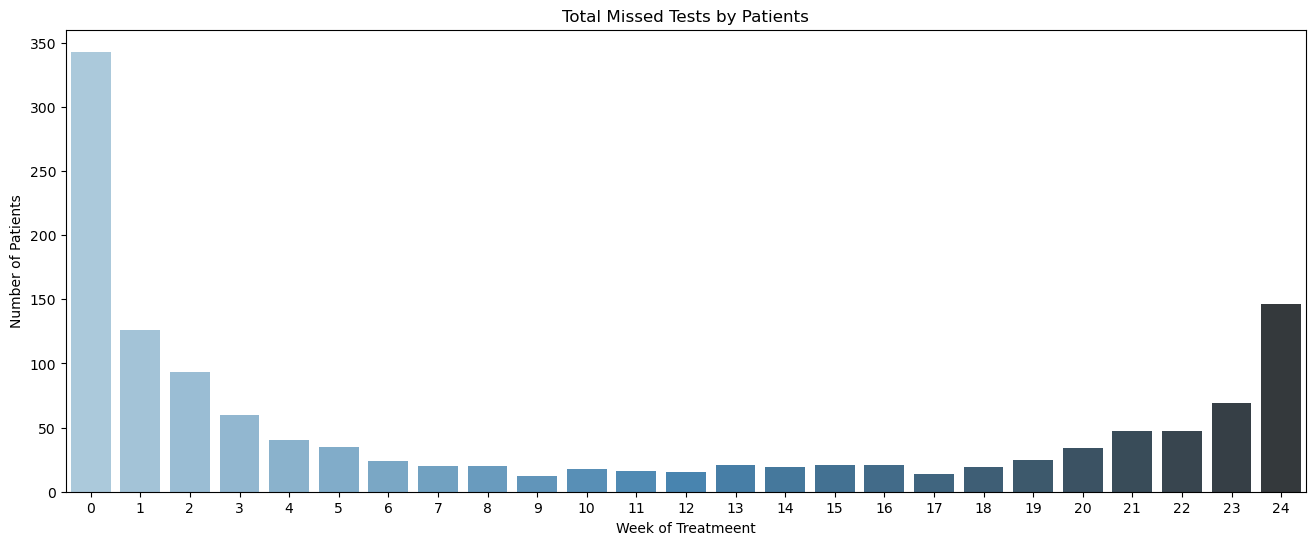

In [16]:
# plot the total missed tests by patients
missed_tests = merged.missed_tests.value_counts().sort_index(ascending=True)

fig = plt.figure(figsize=(16, 6))
ax = sns.countplot(x='missed_tests', data=merged, palette='Blues_d')
ax.set_title('Total Missed Tests by Patients')
ax.set_xlabel('Week of Treatmeent')
ax.set_ylabel('Number of Patients')

# Rotate the X-axis labels to the normal position
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show();

In [17]:
# create table with count of missed tests and rate of missed tests by drug class
meds = merged.groupby('meds').agg(
                                total_patients=('patdeid', 'nunique'),
                                missed_tests=('missed_tests', 'sum')
                                ).reset_index()

# create rate column
meds['rate'] = np.nan

# calculate percent of missed tests by medication class
for i in range(len(meds)):
    meds['rate'][i] = meds['missed_tests'][i] / meds['missed_tests'].sum().round(2)

# round the rate column to 2 decimal places
meds['rate'] = meds['rate'].round(2)

# update row values for interpretability
meds['meds'] = meds['meds'].replace({1.0: 'methadone', 2.0: 'buprenorphine'})

meds

,meds,total_patients,missed_tests,rate
0,methadone,543,3284,0.27
1,buprenorphine,762,8668,0.73


## Hypothesis testing
Let's test the mean difference in missed tests, between the two medication groups

In [18]:
# sample 250 patients from each medication class
group_1 = merged.loc[merged['meds'] == 1].sample(250)
group_2 = merged.loc[merged['meds'] == 2].sample(250)

print(f'Methadone avg missed tests: {group_1.missed_tests.mean()}')
print(f'Bupe avg missed tests: {group_2.missed_tests.mean()}')

Methadone avg missed tests: 5.652
Bupe avg missed tests: 10.992


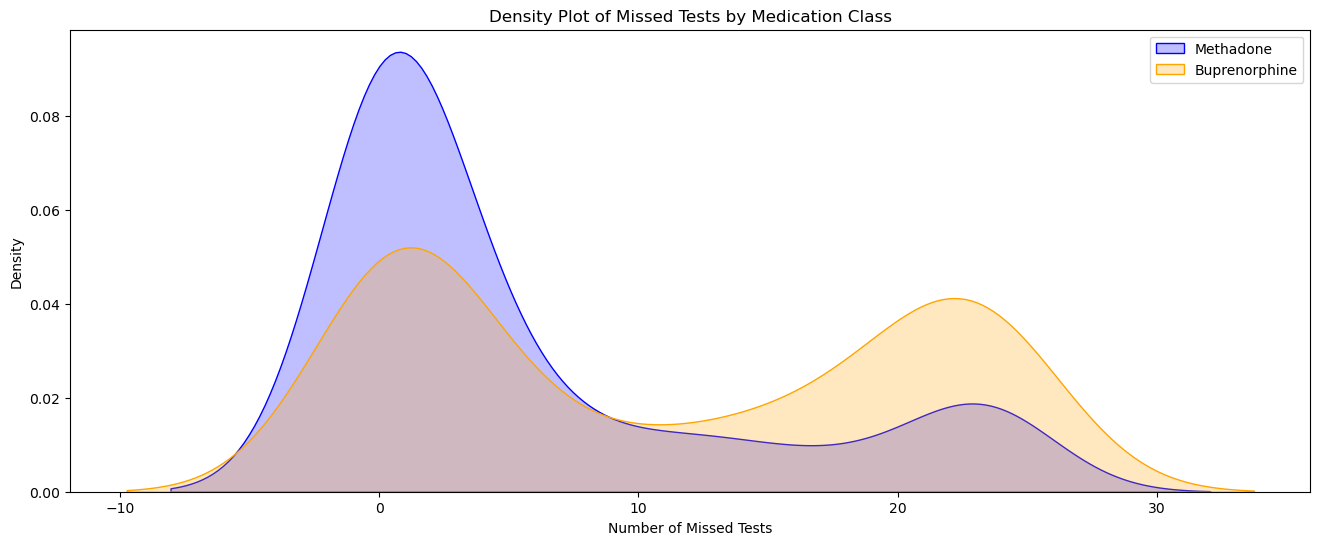

In [19]:
# create density plot to observe the distribution
fig = plt.figure(figsize=(16, 6))
ax = sns.kdeplot(group_1.missed_tests, shade=True, label='Methadone', color='blue')
ax = sns.kdeplot(group_2.missed_tests, shade=True, label='Buprenorphine', color='orange')
ax.set_title('Density Plot of Missed Tests by Medication Class')
ax.set_xlabel('Number of Missed Tests')
ax.set_ylabel('Density')

# Add legend
ax.legend()

plt.show()


In [20]:
# def cohen's d function
def cohens_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

# calculate cohen's d
d = cohens_d(group_1.missed_tests, group_2.missed_tests)

# calculate the effect size
effect_size = d * np.sqrt(2 / (len(group_1) + len(group_2)))

# calculate the confidence interval
ci = effect_size - 1.96 * (np.sqrt(2 / (len(group_1) + len(group_2))))

print(f'Cohen\'s d: {d}')
print(f'Effect Size: {effect_size}')
print(f'Confidence Interval: {ci}')


Cohen's d: -0.594611934108885
Effect Size: -0.03760656071404079
Confidence Interval: -0.16156784499264124


## The null hypothesis 
There is no significant difference in avg missed urine tests between each medication group

<center>

$\alpha$ = 0.05 <br>
$H_0$: $\mu_1$ = $\mu_2$ <br>
$H_A$: $\mu_1$ $\ne$ $\mu_2$ <br>

</center>


In [25]:
# create z test to test the difference in mean missed tests between methadone and bupe
from statsmodels.stats.weightstats import ztest

alpha = 0.05

# methadone and bupe
p = ztest(group_1.missed_tests, group_2.missed_tests, alternative='larger')[1]

if p < alpha:
    print(f'p-value: {p} < {alpha} - reject the null hypothesis')
else:
    print(f'p-value: {p} > {alpha} - fail to reject the null hypothesis')




p-value: 0.9999999999851412 > 0.05 - fail to reject the null hypothesis


## There is no statistical evidence for difference in mean missed tests 

z-score: -6.647963524500465
-0.16156784499264124 0.08635472356455967


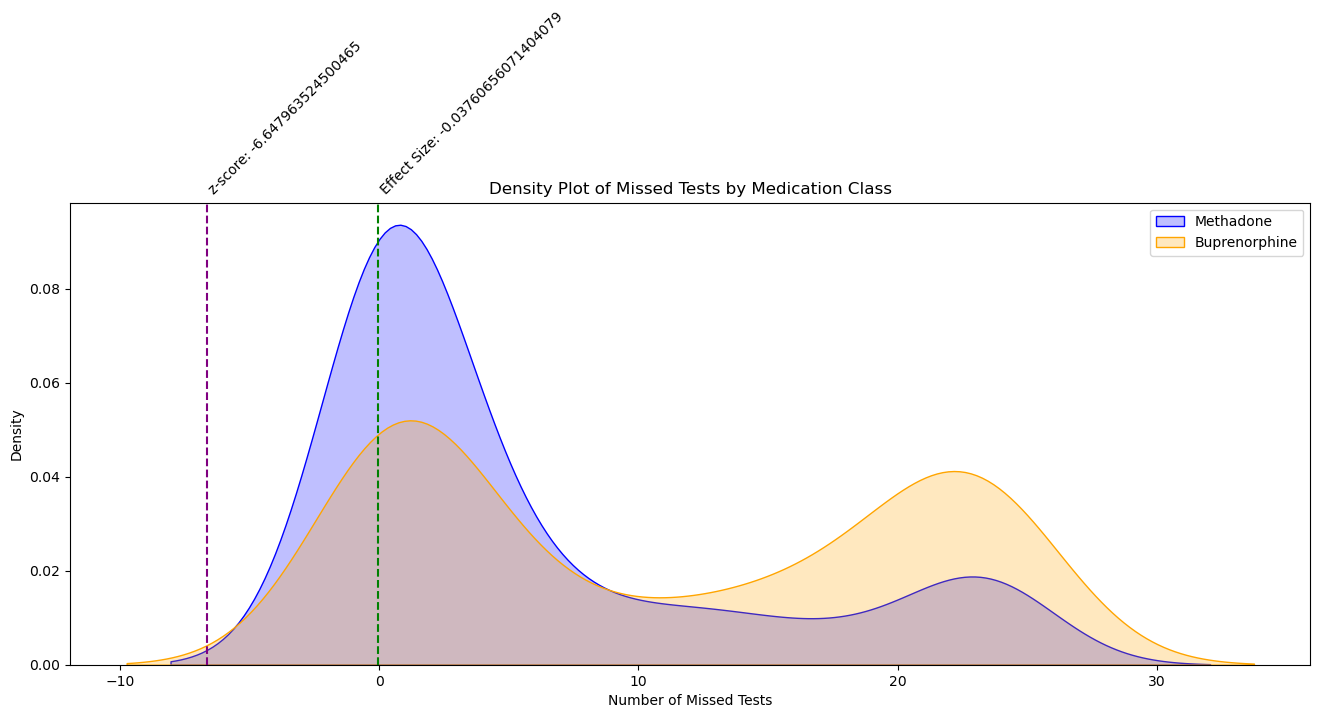

In [26]:
# calculate z score for methadone and bupe
z = ztest(group_1.missed_tests, group_2.missed_tests, alternative='larger')[0]

print(f'z-score: {z}')

# calculate the pvalue 
p = ztest(group_1.missed_tests, group_2.missed_tests, alternative='larger')[1]

# calculate the upper and lower bounds of the confidence interval
lbc = effect_size - 1.96 * (np.sqrt(2 / (len(group_1) + len(group_2))))
ubc = effect_size + 1.96 * (np.sqrt(2 / (len(group_1) + len(group_2))))

print(lbc,ubc)

# plot the z test on density plot
fig = plt.figure(figsize=(16, 6))
ax = sns.kdeplot(group_1.missed_tests, shade=True, label='Methadone', color='blue')
ax = sns.kdeplot(group_2.missed_tests, shade=True, label='Buprenorphine', color='orange')
ax.set_title('Density Plot of Missed Tests by Medication Class')
ax.set_xlabel('Number of Missed Tests')
ax.set_ylabel('Density')

# Add legend
ax.legend()

# Add vertical line for the effect size
ax.axvline(effect_size, color='green', linestyle='--', label='Effect Size')
ax.text(effect_size, 0.1, f'Effect Size: {effect_size}', rotation=45)


# Add vertical line for the z score
ax.axvline(z, color='purple', linestyle='--', label='z-score')
ax.text(z, 0.1, f'z-score: {z}', rotation=45)

plt.show()


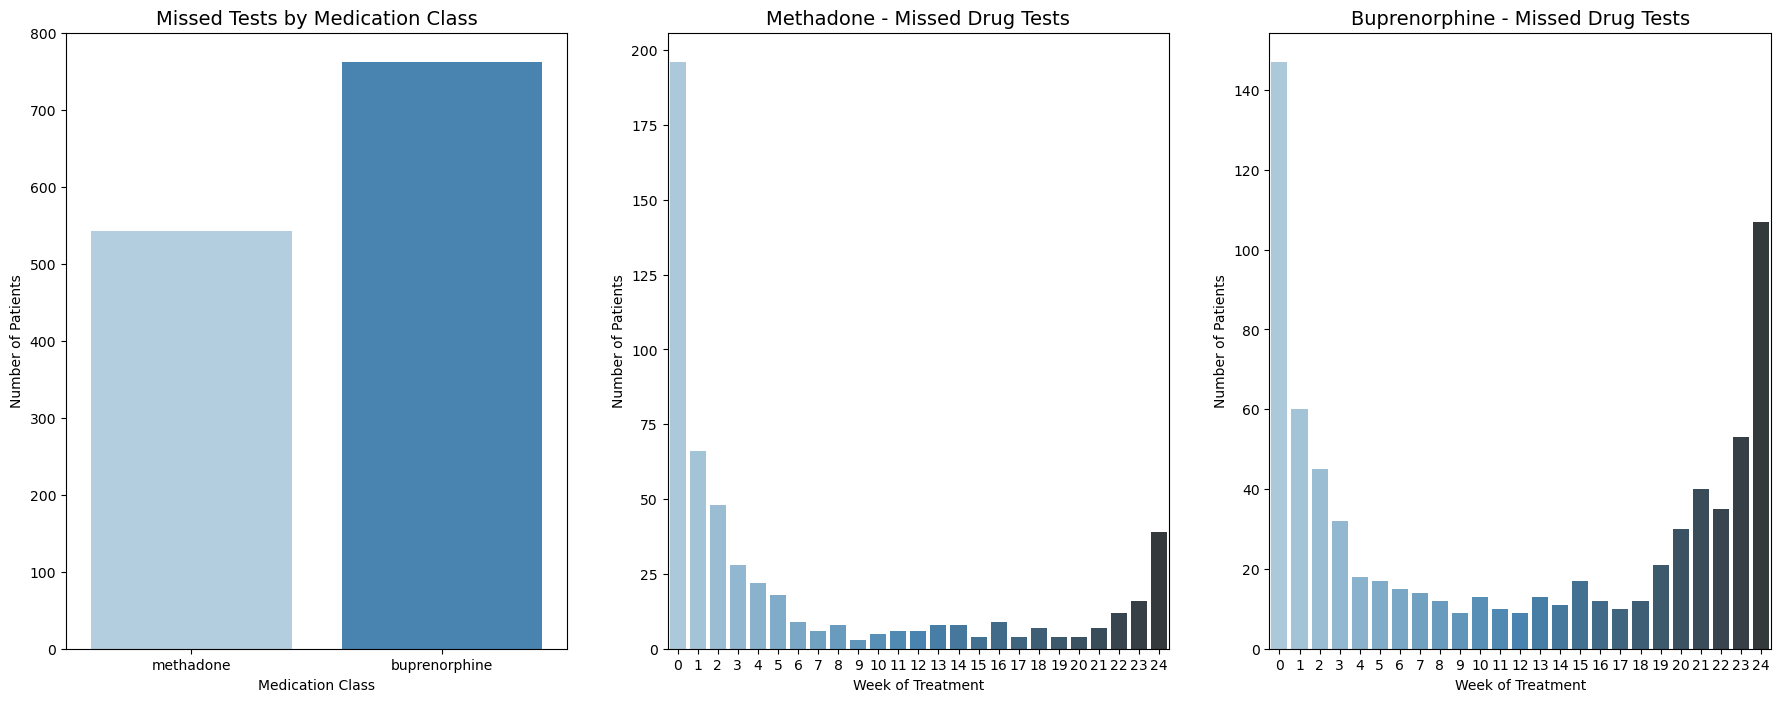

In [24]:
# create a new dataframe for each medication group
med1 = merged[merged['meds'] == 1]
med2 = merged[merged['meds'] == 2]

# create three plots next to each other
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

# plot no shows by medication
sns.countplot(x='meds', data=merged, ax=axes[0], palette='Blues')
axes[0].set_title('Missed Tests by Medication Class' , fontsize=14)
axes[0].set_xlabel('Medication Class')
axes[0].set_ylabel('Number of Patients')

# plot no shows by medication by week
sns.countplot(x='missed_tests', data=med1, ax=axes[1], palette='Blues_d')
axes[1].set_title('Methadone - Missed Drug Tests', fontsize=14)
axes[1].set_xlabel('Week of Treatment')
axes[1].set_ylabel('Number of Patients')

# plot no shows by medication by week
sns.countplot(x='missed_tests', data=med2, ax=axes[2], palette='Blues_d')
axes[2].set_title('Buprenorphine - Missed Drug Tests', fontsize=14)
axes[2].set_xlabel('Week of Treatment')
axes[2].set_ylabel('Number of Patients')

# Rename the 'meds' classes
axes[0].set_xticklabels(['methadone', 'buprenorphine'])
plt.show()


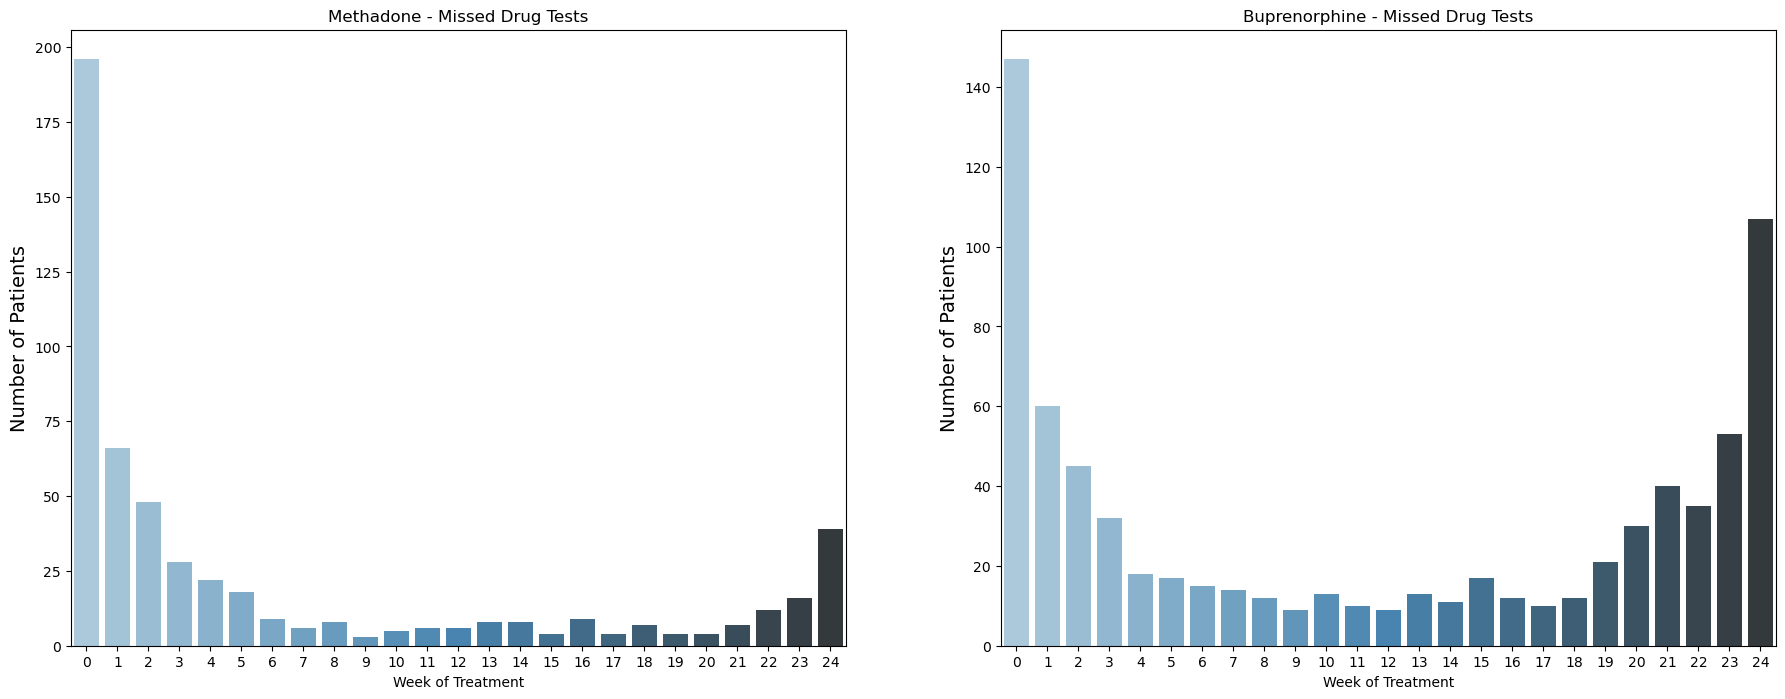

In [11]:
# create 2 plots next to eachother
fig, axes = plt.subplots(1, 2, figsize=(22, 8))


# plot no shows by medication by week
sns.countplot(x='missed_tests', data=med1, ax=axes[0], palette='Blues_d')
axes[0].set_title('Methadone - Missed Drug Tests')
axes[0].set_xlabel('Week of Treatment')
axes[0].set_ylabel('Number of Patients', fontsize=14)

# plot no shows by medication by week
sns.countplot(x='missed_tests', data=med2, ax=axes[1], palette='Blues_d')
axes[1].set_title('Buprenorphine - Missed Drug Tests')
axes[1].set_xlabel('Week of Treatment')
axes[1].set_ylabel('Number of Patients', fontsize=14)

plt.show()